# BERLIN: BUDGET FOR THE PEOPLE?
Having the budget of the city of Berlin at our disposal over several years, together with a detailed view of the demographic changes over the same years, one could ask the question whether the two have anything to do with each other. One could think of, for example, asking whether more money is budgeted per citizes or less, whether money is spent where it is needed, _etc_. As, furthermore, our data is is available on a _per_-district basis, one could even think about comparing the wisdom and foresight of district goverments.

While questions such as these are certainly legitimate, the problem from a data-science point of view is that we only have relatively few observations and many more potential explanatory variables. What follows below is then the current state of an ongoing (and so far futile) exercise in linear-model fitting under the condition of heavy multi-colinearity.

## Prelimiaries
### Import dependencies

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sbn
import statsmodels.api   as sm

from sklearn.linear_model        import LinearRegression
from sklearn.linear_model        import Lasso, LassoCV, lasso_path
from sklearn.linear_model        import ElasticNet, ElasticNetCV, enet_path
from sklearn.kernel_ridge        import KernelRidge
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.decomposition       import PCA
from sklearn.model_selection     import LeavePOut, cross_val_score

from warnings                    import filterwarnings
from itertools                   import combinations

### Notebook settings

In [2]:
filterwarnings('ignore')
%matplotlib notebook

### Define some functions
####  Read a whole time series of files into a dataframe

In [3]:
def read_from_csv(path, prefix, suffix, period):
    file = path + prefix + str(period[0]) + suffix + '.csv'
    
    data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')
    data.ZEIT = period[0]
    data.sort_values('BEZ', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    years = range(period[0] + 1, period[1] + 1)

    for year in years:
        file = path + prefix + str(year) + suffix + '.csv'
    
        year_data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')
        year_data.ZEIT = year
        year_data.sort_values('BEZ', inplace=True)
        year_data.reset_index(drop=True, inplace=True)
        year_data.columns = data.columns
    
        data = data.append(year_data)
        
    data.drop(['RAUMID', 'PGR', 'BZR', 'PLR', 'STADTRAUM'], axis=1, inplace=True)
    data.rename(columns={'ZEIT': 'Jahr', 'HK_EU28': 'HK_EU27', 'BEZ': 'Bezirk'}, inplace=True)
    data = data.astype(int)
    data = data.groupby(['Bezirk', 'Jahr']).sum()
    
    return data

## Read the Data
### First the population data

#### Enter time span and path

In [4]:
minyear = 2008 # minimum is 2008 because no budget data is available before that!
maxyear = 2015 # maximum is 2015 becasue no demographic data is available after that!
path = './data/people/'

#### Read from files and generate set for non-migrants

In [5]:
period = (minyear, maxyear)

mb  = read_from_csv(path, 'EWRMIGRA', '12E_Matrix', period)
org = read_from_csv(path, 'EWRMIGRA', '12H_Matrix', period)
age = read_from_csv(path, 'EWR',      '12E_Matrix', period)
dur = read_from_csv(path, 'WHNDAUER', '_Matrix',    period)
typ = read_from_csv(path, 'WHNLAGE',  '_Matrix',    period)

del minyear
del maxyear
del period
del path

#### Preprocess population data
As we are primarily interested in the potential impact of _relative changes_ in demographics, the population data is ($L_1$-)normalized to the total number of folks living in any given district in any given year. All numbers are, therefore, given in percent of the total population in any given district in any given year.

In [6]:
dur.insert(loc=2, column='5to10', value=(dur['DAU5'] - dur['DAU10']))
dur.insert(loc=2, column='lt5', value=(age['E_E'] - dur['DAU5']))
dur.drop(['EINW10', 'EINW5', 'DAU5', 'PDAU10', 'PDAU5'], axis=1, inplace=True)
dur.rename(columns={'DAU10': 'gt10'}, inplace=True)

org.insert(loc=2, column='HK_EUost', value=(org['HK_EU27'] - org['HK_EU15'] - org['HK_Polen']))
org.drop(['HK_EU27'], axis=1, inplace=True)
org.MH_E = age['E_E'] - mb['MH_E']
org.rename(columns={'MH_E': 'De', 'HK_NZOrd': 'HK_OrgNZord'}, inplace=True)
new_col_names = pd.Index([column[3:] for column in org.columns[1:]])
org.columns = org.columns[:1].append(new_col_names)

tot = age['E_E']
agr = age.copy()
age.drop('E_E', axis=1, inplace=True)
age.drop(age.columns[-9:], axis=1, inplace=True)
age.columns = pd.Index([column[3:].replace('_', 'to').lower() for column in age.columns])

agr.drop('E_E', axis=1, inplace=True)
agr.drop(agr.columns[2:34], axis=1, inplace=True)
agr.columns = pd.Index([column[2:].replace('U', 'to').lower() for column in agr.columns])
agr.drop(['em', 'ew'], axis=1, inplace=True)

typ.columns = pd.Index([column[2:] for column in typ.columns])
typ.rename(columns={'NZORD': 'TypNZord'}, inplace=True)

sex = age.loc[:, :'w'].copy()
sex.columns = pd.Index(['m', 'w'])
age.drop(['m', 'w'], axis=1, inplace=True)

dur, age, agr, sex, org, typ = [feature.apply(lambda x: x / tot)*100 for feature in [dur, age, agr, sex, org, typ]]

del new_col_names
del mb

### Then the processed budget data

In [7]:
budget = pd.read_csv('./consolidated_2008-2015.csv')
budget.set_index(['District', 'Year'], inplace=True)

## Visually Inspect Data
The budget is always given on a _per_-person basis as little else seems to make sense.

<IPython.core.display.Javascript object>


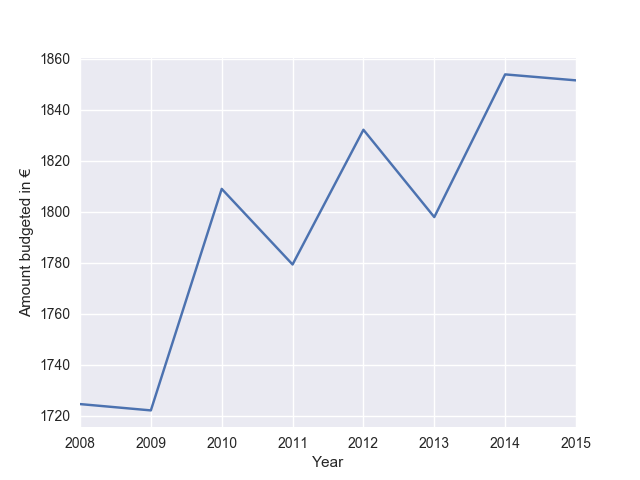

In [8]:
plot_data = budget['Total'].sum(level=1) / tot.sum(level=1)

fig, ax = plt.subplots(num='Total Budget per Person in Berlin overall')
plot_data.plot(ax=ax)

ax.set_ylabel('Amount budgeted in €')
ax.set_xticklabels(plot_data.index.values.astype(str));

<IPython.core.display.Javascript object>


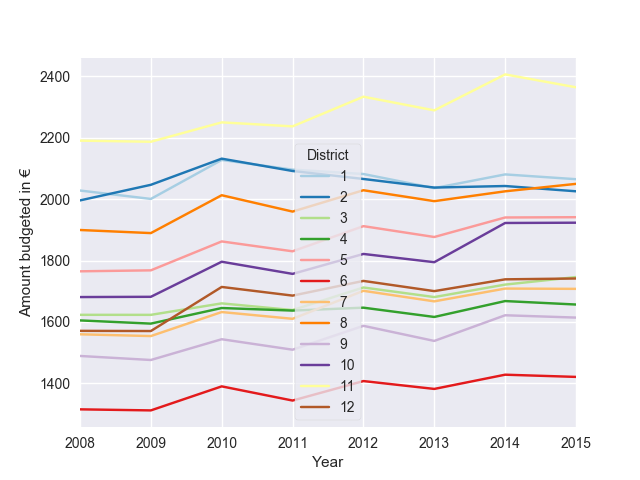

In [9]:
plot_data = budget['Total'].unstack('District') / tot.unstack('Bezirk')

fig, ax = plt.subplots(num='Total Budget per Person in each District')
plot_data.plot(colormap='Paired', ax=ax)

ax.set_ylabel('Amount budgeted in €')
ax.set_xticklabels(plot_data.index.values.astype(str))
ax.legend(loc='best', title='District', frameon=True, fancybox=True, framealpha=0.8);

#### Budget per person and chapter in a certain district
Enter the desired district number below, kepping in mind that Berlin has no more than 12 total.

<IPython.core.display.Javascript object>


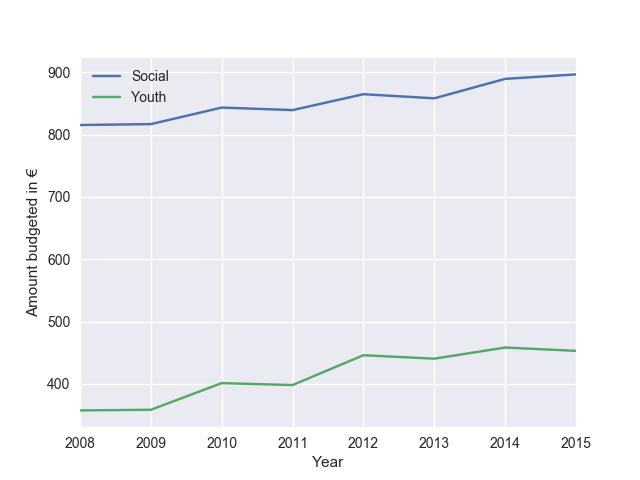

In [10]:
district = 7 # Enter district number between 1 and 12 here

plot_data = budget.drop('Total', axis=1).loc[district].apply(lambda x: x / tot.loc[district])
fig, ax = plt.subplots(num='Budget per Person and Chapter in District ' + str(district))
plot_data.plot(ax=ax)

ax.set_ylabel('Amount budgeted in €')
ax.set_xticklabels(plot_data.index.values.astype(str));

### Try out a few individual regressors to get a feeling for what works
Enter the desired district number and chapter below, kepping in mind that Berlin has no more than 12 districts.

In [11]:
district = 8
chapter  = 'Youth'

y = budget.loc[district, chapter] / tot.loc[district]
plot_data = sex.join(org).join(age).join(dur).join(typ)
i_pred = 0

#### No repeatedly execute the cell below

<IPython.core.display.Javascript object>


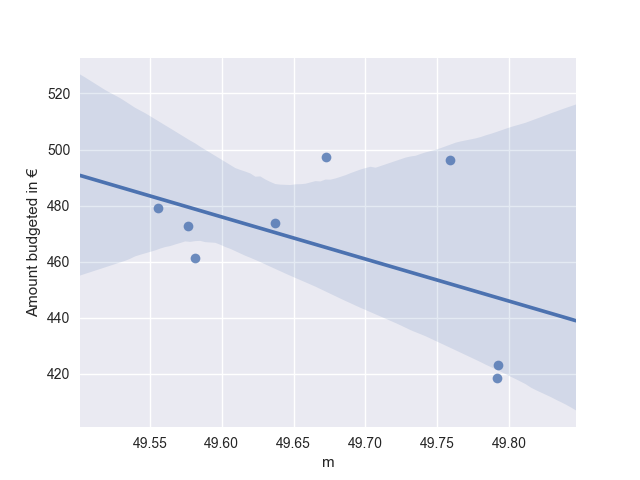

In [12]:
fig, ax = plt.subplots(num='Inspect how "linear" a line-fit looks for predictor: ' + plot_data.columns[i_pred])

x = plot_data.loc[district].iloc[:, i_pred]

sbn.regplot(x, y, ax)
ax.set_ylabel('Amount budgeted in €')

if i_pred < plot_data.shape[1]-1:
    i_pred += 1

## Analyse Data for One Expense Category at a Time
### Set up
#### Chose district, expense category, and predictors

In [13]:
district = 6
chapter  = 'Youth'

data = agr

#### Center the data and drop all predictors that give a negative slope
We are not interested in a "base-rate" of funding per person and, therefore, drop the intercept. Also a *de*creasing percentage of a certain population group should not lead to an *in*crease in budget. Therefore, we try not to produce negative coefficients. Allowing them might increase the quality of the fit but severly impede its interpretability. This is also the reason, why we will not consider (kernel-)ridge regression in the following.

In [14]:
X = data.loc[district].apply(lambda x: x - x.mean()).copy()

y = budget.loc[district, chapter] / tot.loc[district]
y -= y.mean()

drop_list = []

for column in X.columns:
    x = X[column]
    fit = sm.OLS(y, x, hasconst=False).fit()
    if (fit.params <= 0).all():
        drop_list.append(column)
        
X.drop(drop_list, axis=1, inplace=True)

n_pred = X.shape[1]
print('Number of Predictors: ', n_pred)

del drop_list

Number of Predictors:  5


#### Enter maximum number of predictors to consider

In [15]:
k_pred_max = 3

#### Set Paramters for the linear regression used in cross validation and for the cross validation itself

In [16]:
lin_reg = LinearRegression(fit_intercept=False, normalize=False)

cv = LeavePOut(3)

### Best-subset selection

In [17]:
bss_scores = []
bss_preds  = []

for k_pred in range(1, k_pred_max + 1):
    pred_combs = combinations(range(n_pred), k_pred)
    r2_max = -1000000
    best_preds = None

    for preds in pred_combs:
        x = X.iloc[:, preds]    
        fit = sm.OLS(y, x, hasconst=False).fit()
        if (fit.params > 0).all():
            if (fit.rsquared > r2_max):
                r2_max = fit.rsquared
                best_preds = x.columns.tolist()

    if best_preds:
        fit = sm.OLS(y, X.loc[:, best_preds], hasconst=False).fit()
        bss_scores.append([fit.aic, fit.bic, fit.rsquared_adj])
        bss_preds.append(best_preds)

k_pred_max = len(bss_scores)
bss_scores = pd.DataFrame(bss_scores,
                          index=range(1, k_pred_max + 1),
                          columns=['AIC', 'BIC', 'R2_adj'])

#### Compute cross-validation score

In [18]:
cv_scores=[]

for k_pred in range(k_pred_max):
    x = X.loc[:, bss_preds[k_pred]]    
    cv_score = cross_val_score(lin_reg, x, y, cv=cv).mean()    
    cv_scores.append(cv_score)

bss_scores['CV'] = cv_scores

#### Plot various scores to pick number of predictors in linear fit

<IPython.core.display.Javascript object>


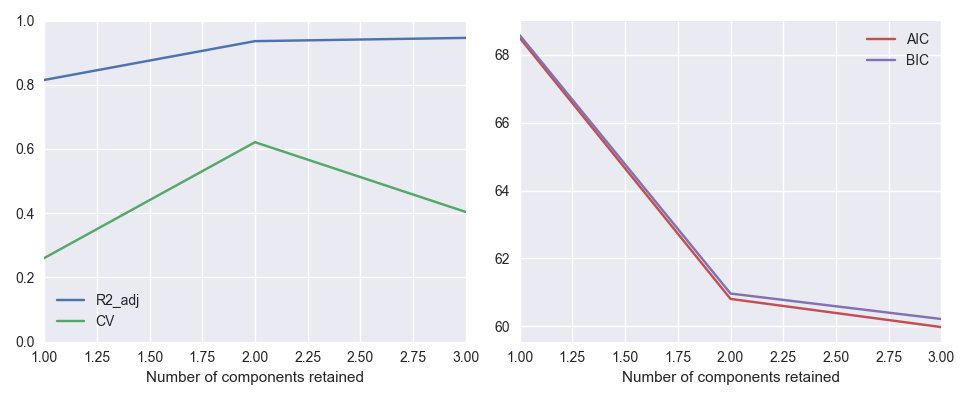

In [19]:
fig = plt.figure(num='Asses Best Subset Selection', figsize=(9.7, 4))

r2s_ax = fig.add_subplot(1,2,1)
aic_ax = fig.add_subplot(1,2,2)

bss_scores.loc[:, :'BIC'].plot(ax=aic_ax, color=('#c44e52', '#8172b2'))
bss_scores.loc[:, 'R2_adj':].plot(ax=r2s_ax)

r2s_ax.set_ylim(bottom=0.0, top=1.0);
r2s_ax.set_xlabel('Number of components retained')
aic_ax.set_xlabel('Number of components retained')

fig.tight_layout()

### Forward selection

In [20]:
fws_scores = []
fws_preds  = []

for k_pred in range(1, k_pred_max + 1):
    new_preds = X.columns.drop(fws_preds)
    r2_max = -100000

    for new_pred in new_preds:
        preds = fws_preds.copy()
        preds.append(new_pred)        
        x = X.loc[:, preds]
        fit = sm.OLS(y, x, hasconst=False).fit()
        
        if (fit.params > 0).all() & (fit.rsquared > r2_max):
            r2_max = fit.rsquared
            best_pred = new_pred[:]
    
    fws_preds.append(best_pred)
    fit = sm.OLS(y, X.loc[:, fws_preds], hasconst=False).fit()
    fws_scores.append([fit.aic, fit.bic, fit.rsquared_adj])

fws_scores = pd.DataFrame(fws_scores, 
                          index=range(1, k_pred_max + 1),
                          columns=['AIC', 'BIC', 'R2_adj'])

#### Compute cross-validation score

In [21]:
cv_scores=[]

for k_pred in range(1, k_pred_max + 1):
    x = X.loc[:, fws_preds[:k_pred]]    
    cv_score = cross_val_score(lin_reg, x, y, cv=cv).mean()    
    cv_scores.append(cv_score)

fws_scores['CV'] = cv_scores

#### Plot various scores to pick number of predictors in linear fit

<IPython.core.display.Javascript object>


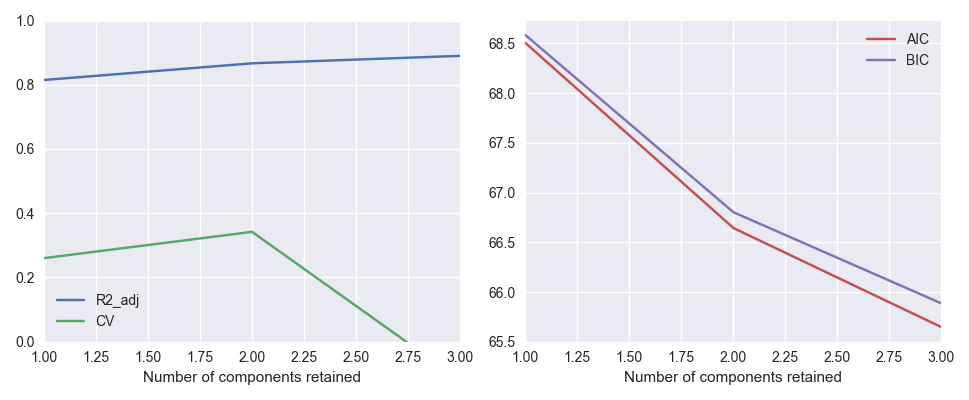

In [22]:
fig = plt.figure(num='Asses Forward Selection', figsize=(9.7, 4))

r2s_ax = fig.add_subplot(1,2,1)
aic_ax = fig.add_subplot(1,2,2)

fws_scores.loc[:, :'BIC'].plot(ax=aic_ax, color=('#c44e52', '#8172b2'))
fws_scores.loc[:, 'R2_adj':].plot(ax=r2s_ax)

r2s_ax.set_ylim(bottom=0.0, top=1.0)
r2s_ax.set_xlabel('Number of components retained')
aic_ax.set_xlabel('Number of components retained')

fig.tight_layout()

### Elastic Net (incl. Lasso)

#### Set parameters
Keep in mind that an $L_1$-ratio of 1.0 corresponds to LASSO. So make sure to inluced that number in the list below if you care for the method.

In [23]:
elnet_params = {'fit_intercept': False,
                    'normalize': False,
                     'max_iter': 1000000,
                          'tol': 1e-5,
                     'positive': True,
                    'selection': 'random'}

cv_parameter = {          'eps': 1e-6,
                     'n_alphas': 100,
                           'cv': cv}

l1_ratios = [.1 , .3, .5, .7, .9, .95, .99, 1.0]

#### Find best regularization parameter $\alpha$ and best $L_1$-ratio by cross-validation

<IPython.core.display.Javascript object>


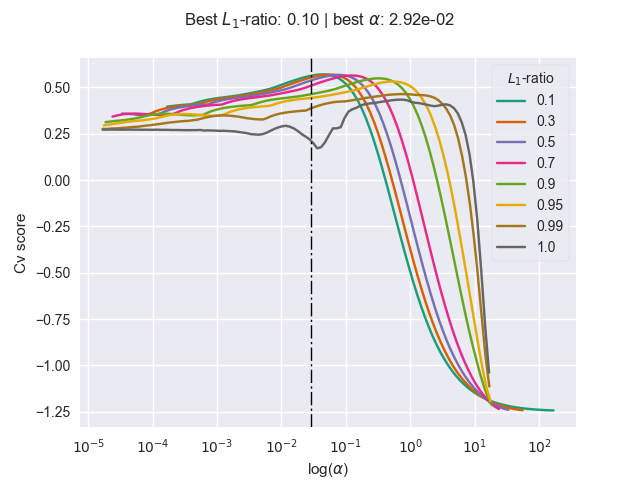

In [24]:
elnet = ElasticNetCV(**elnet_params, **cv_parameter, l1_ratio=l1_ratios)
elnet.fit(X, y)

best_a = elnet.alpha_
alphas = elnet.alphas_

fig, ax = plt.subplots(num='Cross-validation Scores for Elastic Net')
fig.suptitle('Best $L_1$-ratio: ' + '{:.2f}'.format(elnet.l1_ratio_) +
             r' | best $\alpha$: ' + '{:.2e}'.format(best_a))
ax.set_prop_cycle('color', plt.cm.Dark2([i/len(l1_ratios) for i in range(len(l1_ratios))]))

for i in range(len(l1_ratios)):
    cv_scores = []
    for alpha in alphas[i]:
        elnet = ElasticNet(alpha=alpha, l1_ratio=l1_ratios[i], **elnet_params)
        cv_score = cross_val_score(elnet, X, y, cv=cv).mean()
        cv_scores.append(cv_score)
    ax.semilogx(alphas[i], cv_scores, label=str(l1_ratios[i]))
    
ax.axvline(x=best_a, color = 'k', linestyle = '-.', linewidth=1.0);
ax.set_xlabel(r'log($\alpha$)')
ax.set_ylabel('Cv score'  )
ax.legend(loc='best', title='$L_1$-ratio', frameon=True, fancybox=True, framealpha=0.8);

#### Set your choice for $\alpha$ and $L_1$-ratio here, and examine the elastic-net path

<IPython.core.display.Javascript object>


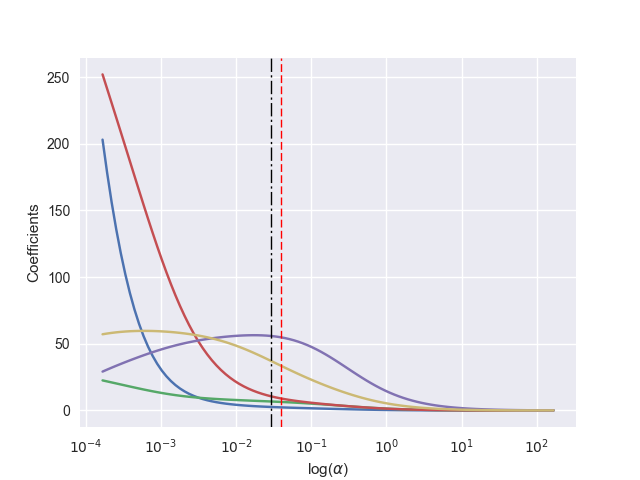

In [25]:
my_alpha = 4.0e-2  # Enter you choice for the regularization parameter here
l1_ratio = 0.10    # Enter you choice (from the list defined above) for the L1-ratio here

idx = l1_ratios.index(l1_ratio)
alphas_elnet, coefs_elnet, _ = enet_path(X, y, alphas=alphas[idx], l1_ratio=l1_ratios[idx], **elnet_params)

fig, ax = plt.subplots(num='Elastic Net Regularization Paths')

ax.semilogx(alphas_elnet, coefs_elnet.T)
ax.axvline(x=best_a,   color = 'k', linestyle = '-.', linewidth=1.0)
ax.axvline(x=my_alpha, color = 'r', linestyle = '--', linewidth=1.0)
ax.set_xlabel(r'log($\alpha$)')
ax.set_ylabel('Coefficients');

#### Lock in your choice for later
Set the final $\alpha$ you want to retain for comparison in the first line of the cell below

In [26]:
alpha = best_a  # 'my_alpha' or 'best_a'

elnet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, **elnet_params)
elnet.fit(X, y)
elnet_score = cross_val_score(elnet, X, y, cv=cv).mean()
elnet_preds = X.loc[:, (elnet.coef_ > 0)].columns.tolist()

As we do not want to allow negative coefficients, we will not consider (kernel-)ridge regression here.

### *P*artial *L*east *S*quares regression
At this point (if not earlier), one could argue that we should normalize the data to unit standard deviation in order to pick up correlations between regressors with little variance and the observations. I would however, argue against such a procedure in the present case because it simply makes no sense to see the budget per person increase by a substantial amount becasue of a tiny shift in demographics.

#### Include all predictors now because negative weights will happen anyway and negative coefficients are therefore hard to avoid

In [27]:
X = data.loc[district].apply(lambda x: x - x.mean()).copy()

y = budget.loc[district, chapter] / tot.loc[district]
y -= y.mean()

n_pred = X.shape[1]
print('Number of Predictors is now: ', n_pred)

Number of Predictors is now:  9


#### Enter maximum number of predictors to consider

In [28]:
k_pred_max = 5

#### Perform actual PLS regression

In [29]:
pls_params = {   'scale': False,
              'max_iter': 1000,
                   'tol': 1e-6}

plsreg_scores = []

for k_pred in range(1, k_pred_max + 1):
    plsreg = PLSRegression(n_components=k_pred, **pls_params)
    plsreg.fit(X, y)    
    X_red = plsreg.transform(X)     
    cv_score = cross_val_score(lin_reg, X_red, y, cv=cv).mean()    
    fit = sm.OLS(y, X_red, hasconst=False).fit()
    plsreg_scores.append([fit.aic, fit.bic, fit.rsquared_adj, cv_score])
    
plsreg_scores = pd.DataFrame(   data=plsreg_scores,
                               index=range(1, k_pred_max + 1),
                             columns=['AIC', 'BIC', 'R2_adj', 'CV'])
plsreg_preds  = pd.DataFrame(   data=plsreg.x_loadings_.T,
                               index=range(1, k_pred_max + 1),
                             columns=X.columns)

#### Plot various scores to pick number of predictors in linear fit

<IPython.core.display.Javascript object>


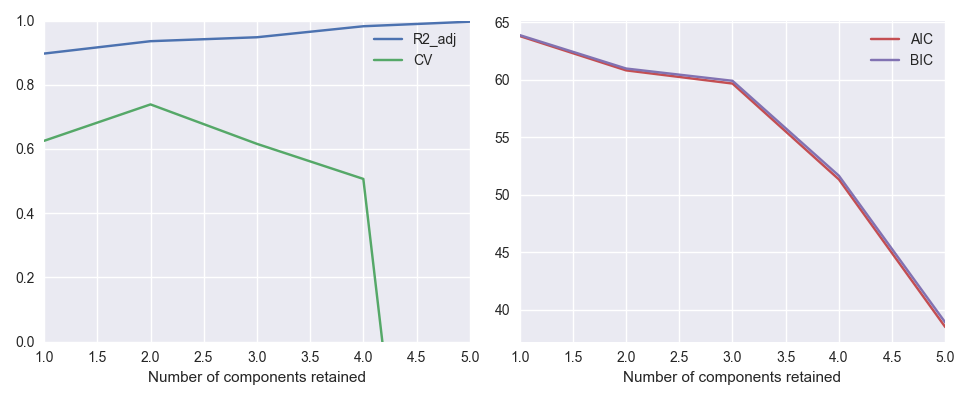

In [30]:
fig = plt.figure(num='Asses PLS regression', figsize=(9.7, 4))

r2s_ax = fig.add_subplot(1,2,1)
aic_ax = fig.add_subplot(1,2,2)

plsreg_scores.loc[:, :'BIC'].plot(ax=aic_ax, color=('#c44e52', '#8172b2'))
plsreg_scores.loc[:, 'R2_adj':].plot(ax=r2s_ax)

r2s_ax.set_ylim(bottom=0.0, top=1.0)
r2s_ax.set_xlabel('Number of components retained')
aic_ax.set_xlabel('Number of components retained')

fig.tight_layout()

### *C*anonical *C*orrelation *A*nalysis

In [31]:
cca = CCA(n_components=1, **pls_params)
cca.fit(X, y)
    
X_red = cca.transform(X) 
    
cv_score = cross_val_score(lin_reg, X_red, y, cv=cv).mean()
    
fit = sm.OLS(y, X_red, hasconst=False).fit()

cca_scores = [fit.aic, fit.bic, fit.rsquared_adj, cv_score]
cca_scores = pd.DataFrame([cca_scores], index=[1], columns=['AIC', 'BIC', 'R2_adj', 'CV'])
cca_preds = pd.DataFrame(cca.x_loadings_.T, index=[1], columns=X.columns)

### PCA for comparison

In [32]:
pca = PCA(n_components=3)
pca.fit(X);

### Summary and graphical check
#### PLS, PCA, CCA and correlations

 BEST SUBSET SELECTION - PREDICTORS:
1 ['65to80']
2 ['to1', '15to18']
3 ['to1', '15to18', '80to110']

 FORWARD SELECTION - PREDICTORS: 
 ['65to80', '80to110', '15to18'] 

 ELASTIC NET - PREDICTORS:
 ['to1', '1to6', '15to18', '65to80', '80to110']


<IPython.core.display.Javascript object>


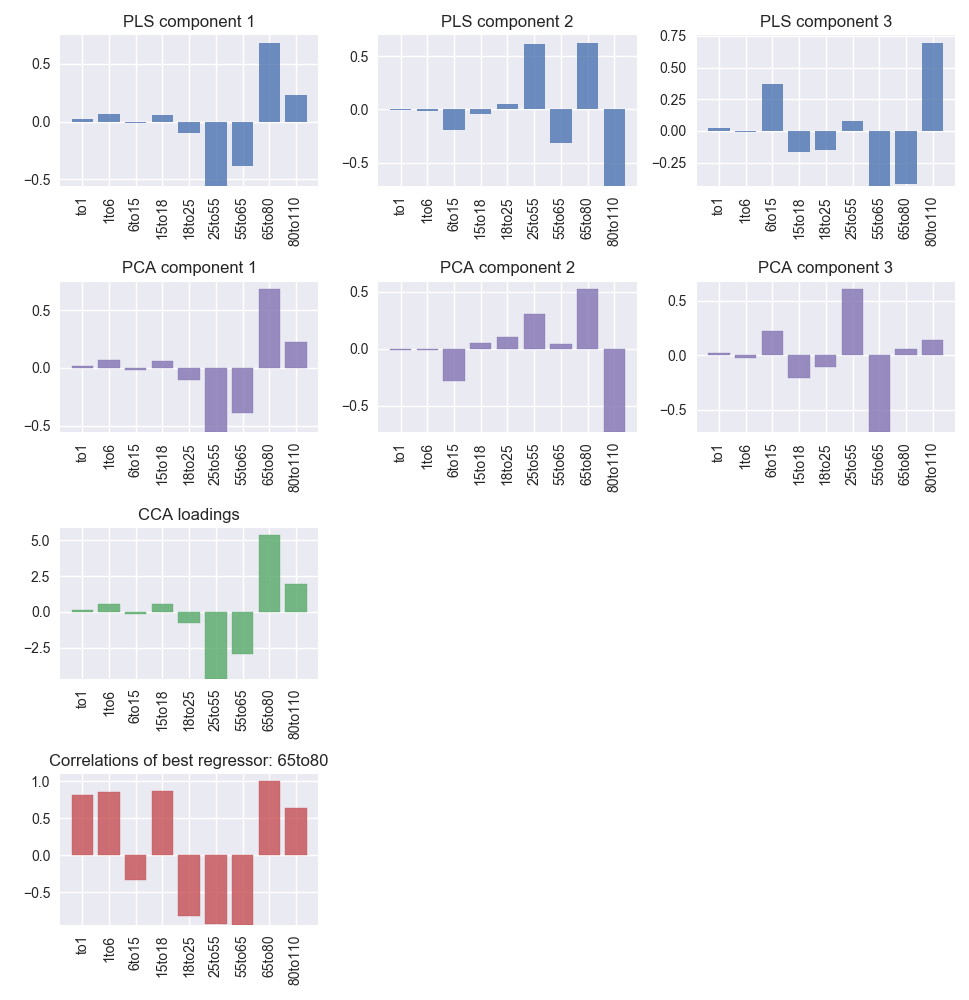

In [33]:
print(' BEST SUBSET SELECTION - PREDICTORS:')
for k_pred in range(len(bss_preds)):
    print(k_pred + 1, bss_preds[k_pred])
print('\n FORWARD SELECTION - PREDICTORS: \n', fws_preds, '\n')
print(' ELASTIC NET - PREDICTORS:\n', elnet_preds)

fig = plt.figure(num='PLS and CCA components by loading', figsize=(9.7, 10))

sign = np.sign(plsreg_preds.loc[1, bss_preds[0][0]])

ax = fig.add_subplot(431)
ax.bar(range(0, n_pred), sign * plsreg_preds.loc[1], align='center', alpha=0.8)
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('PLS component 1')

ax = fig.add_subplot(432)
ax.bar(range(0, n_pred), plsreg_preds.loc[2], align='center', alpha=0.8)
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('PLS component 2')

ax = fig.add_subplot(433)
ax.bar(range(0, n_pred), plsreg_preds.loc[3], align='center', alpha=0.8)
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('PLS component 3')

pca_idx = plsreg_preds.columns.get_loc(bss_preds[0][0])
sign = np.sign(pca.components_[0, pca_idx])

ax = fig.add_subplot(434)
ax.bar(range(0, n_pred), sign * pca.components_[0], align='center', alpha=0.8, facecolor='#8172b2', edgecolor='#8172b2')
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('PCA component 1')

max_idx = plsreg_preds.loc[2].abs().idxmax()
pca_idx = plsreg_preds.columns.get_loc(max_idx)
sign = np.sign(plsreg_preds.loc[2, max_idx] * pca.components_[1, pca_idx])

ax = fig.add_subplot(435)
ax.bar(range(0, n_pred), sign * pca.components_[1], align='center', alpha=0.8, facecolor='#8172b2', edgecolor='#8172b2')
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('PCA component 2')

max_idx = plsreg_preds.loc[3].abs().idxmax()
pca_idx = plsreg_preds.columns.get_loc(max_idx)
sign = np.sign(plsreg_preds.loc[3, max_idx] * pca.components_[2, pca_idx])

ax = fig.add_subplot(436)
ax.bar(range(0, n_pred), sign * pca.components_[2], align='center', alpha=0.8, facecolor='#8172b2', edgecolor='#8172b2')
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('PCA component 3')

sign = np.sign(cca_preds.loc[1, bss_preds[0][0]])

ax = fig.add_subplot(437)
ax.bar(range(0, n_pred), sign * cca_preds.loc[1], align='center', alpha=0.8, facecolor='#55a868', edgecolor='#55a868')
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('CCA loadings')

ax = fig.add_subplot(4,3,10)
ax.bar(range(0, n_pred), X.corr().loc[bss_preds[0]].squeeze(), align='center', alpha=0.8, facecolor='#c44e52', edgecolor='#c44e52')
ax.set_xticks(range(0, n_pred))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_title('Correlations of best regressor: ' + bss_preds[0][0])

fig.tight_layout()

#### Scores of all methods

In [34]:
print(' BEST SUBSET SELECTION - SCORES:')
print(bss_scores)
print('\n FORWARD SELECTION - SCORES:')
print(fws_scores)
print('\n ELASTIC NET CV-SCORES:', elnet_score)
print('\n PLS REGRESSION - SCORES:')
print(plsreg_scores)
print('\n CCA - SCORES:')
print(cca_scores)

 BEST SUBSET SELECTION - SCORES:
         AIC        BIC    R2_adj        CV
1  68.504284  68.583726  0.814825  0.260212
2  60.806538  60.965421  0.935721  0.621162
3  59.975327  60.213652  0.945856  0.403873

 FORWARD SELECTION - SCORES:
         AIC        BIC    R2_adj        CV
1  68.504284  68.583726  0.814825  0.260212
2  66.644434  66.803317  0.866651  0.342023
3  65.648437  65.886762  0.889966 -0.119317

 ELASTIC NET CV-SCORES: 0.562935430875

 PLS REGRESSION - SCORES:
         AIC        BIC    R2_adj        CV
1  63.807757  63.887199  0.897051  0.625451
2  60.822344  60.981227  0.935594  0.738778
3  59.675792  59.914117  0.947846  0.615986
4  51.343319  51.661085  0.982082  0.506822
5  38.503327  38.900534  0.996262 -2.328324

 CCA - SCORES:
          AIC         BIC  R2_adj   CV
1 -463.938208 -463.858766     1.0  1.0


#### Check again the linear regression with your favourite predictor

<IPython.core.display.Javascript object>


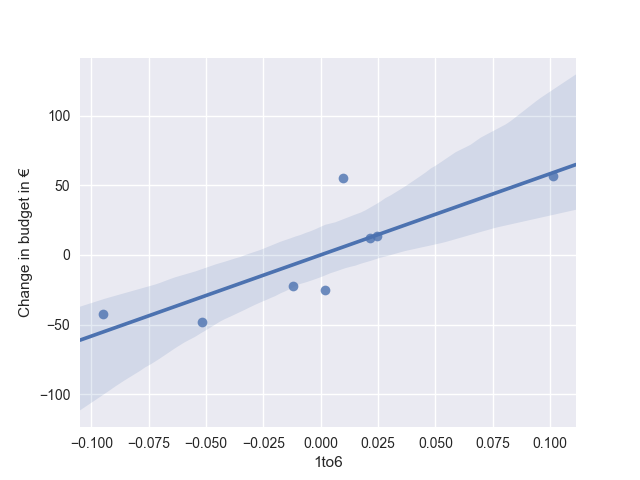

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     14.39
Date:                Wed, 21 Jun 2017   Prob (F-statistic):            0.00677
Time:                        23:45:20   Log-Likelihood:                -36.064
No. Observations:                   8   AIC:                             74.13
Df Residuals:                       7   BIC:                             74.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
1to6         583.3356    153.761      3.794      0.007       219.749   946.922
==============================================================================
Omnibus:                        6.058   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                1.843
Skew:                           1.141   Prob(JB):                        0.398
Kurtosis:                       3.565   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
pred = '1to6'

x = X[pred]
fig, ax = plt.subplots(num='Graphically inspect results for predictor: ' + pred)
sbn.regplot(x=x, y=y, ax=ax);
ax.set_ylabel('Change in budget in €')

fit = sm.OLS(y, x, hasconst=False).fit()
fit.summary()

## Concluding Remarks
Despite having covered a fair portion of available linear models, heavy collinearity among regressor variables seems to prevent us from delievering a model with clear _explanatory_ power. For an elegant solution to this problem, see the notebook `PlanBayesian`. 